# Active Session 5: Neural Networks -- Fundamentals

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cihan-ates/data-driven-engineering/blob/master/DDE_I_ML_Dynamical_Systems/Lecture%207/Lecture_7.ipynb)


# Important Note

Lecture notes and notebooks must not be copied and/or distributed without the express permission of ITS.





# 1. Problem Definition: Probe into the Data

In this dataset, we will look into the relationship between airfoil design and its relationship with noise generation. 

This NASA data set was obtained from a series of aerodynamic and acoustic tests of two and three-dimensional airfoil blade sections conducted in an anechoic wind tunnel. It comprises different size NACA 0012 airfoils at various wind tunnel speeds and angles of attack. The span of the airfoil and the observer position were the same in all of the experiments. 

Attribute Information:

This problem has the following inputs:
1. Frequency, in Hertz.
2. Angle of attack, in degrees.
3. Chord length, in meters.
4. Free-stream velocity, in meters per second.
5. Suction side displacement thickness, in meters.

The only output is:
6. Scaled sound pressure level, in decibels. 


# 2. Preparing the enviroment

Import the Python libraries that we will need to (i) load the data, (ii) analyze it, (iii) create our model, (iv) process the results.

In [1]:
!pip install ipython-autotime
%load_ext autotime

time: 1.89 ms (started: 2021-12-03 09:11:06 +00:00)


In [2]:
#Importing the necessary libraries
import math
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

time: 353 ms (started: 2021-12-03 09:11:06 +00:00)


In [3]:
# Data Preparation and Scoring
from sklearn import preprocessing as pp
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from matplotlib.colors import LogNorm


time: 207 ms (started: 2021-12-03 09:11:07 +00:00)


In [4]:
# ML Algorithms to be used
import tensorflow as tf
from tensorflow import keras
from keras import optimizers, models, layers, regularizers
tf.__version__


'2.7.0'

time: 2.35 s (started: 2021-12-03 09:11:07 +00:00)


# 3. Pre-processing


## Loading the Data

We need to upload the dataset to Colab enviroment. Pandas library is a practical way to load and read the data from an url. Since the data is only given as tabulated values, we need to add the name of the features as well. 

In [5]:
# Loading the data
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat'
new_names = ['frequency','angle_attack','chord_length','Free-stream_velocity','displacement_thickness','sound_pressure']
data = pd.read_csv(url, names=new_names, delimiter='\t')
data.head()

,frequency,angle_attack,chord_length,Free-stream_velocity,displacement_thickness,sound_pressure
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


time: 1.1 s (started: 2021-12-03 09:11:09 +00:00)


## Data Exploration
Here we will look into the statistics of the data, identify any missing values or categorical features that is needed to be further process.

Let’s analyze our dataset first. Use dataset.head(n) to display top n data. You can change dataset.head(n) to dataset.sample(n) to display randomly picked data:

In [6]:
 data.head(5)

,frequency,angle_attack,chord_length,Free-stream_velocity,displacement_thickness,sound_pressure
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


time: 22 ms (started: 2021-12-03 09:11:11 +00:00)


In [7]:
data.sample(5)

,frequency,angle_attack,chord_length,Free-stream_velocity,displacement_thickness,sound_pressure
476,3150,0.0,0.1524,55.5,0.001727,127.753
551,4000,5.4,0.1524,71.3,0.004012,121.431
380,800,5.3,0.2286,39.6,0.006143,129.491
373,8000,5.3,0.2286,71.3,0.005194,114.900
6,3150,0.0,0.3048,71.3,0.002663,125.201


time: 34 ms (started: 2021-12-03 09:11:11 +00:00)


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   frequency               1503 non-null   int64  
 1   angle_attack            1503 non-null   float64
 2   chord_length            1503 non-null   float64
 3   Free-stream_velocity    1503 non-null   float64
 4   displacement_thickness  1503 non-null   float64
 5   sound_pressure          1503 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 70.6 KB
time: 18.8 ms (started: 2021-12-03 09:11:11 +00:00)


Let's look into the statistics of the data. This is usually a good starting point to have an idea obout the range of the data, its nature, as well as the missing information for different features:

In [9]:
data.describe()

,frequency,angle_attack,chord_length,Free-stream_velocity,displacement_thickness,sound_pressure
count,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000
mean,2886.380572,6.782302,0.136548,50.860745,0.011140,124.835943
std,3152.573137,5.918128,0.093541,15.572784,0.013150,6.898657
min,200.000000,0.000000,0.025400,31.700000,0.000401,103.380000
25%,800.000000,2.000000,0.050800,39.600000,0.002535,120.191000
50%,1600.000000,5.400000,0.101600,39.600000,0.004957,125.721000
75%,4000.000000,9.900000,0.228600,71.300000,0.015576,129.995500
max,20000.000000,22.200000,0.304800,71.300000,0.058411,140.987000


time: 36.8 ms (started: 2021-12-03 09:11:11 +00:00)


If not defined by the user, you can also explore the features with the following command:

In [10]:
data.columns


Index(['frequency', 'angle_attack', 'chord_length', 'Free-stream_velocity',
       'displacement_thickness', 'sound_pressure'],
      dtype='object')

time: 4.54 ms (started: 2021-12-03 09:11:11 +00:00)


It is also possible to explore individual features:

In [11]:
data['sound_pressure'].median()

125.721

time: 3.79 ms (started: 2021-12-03 09:11:11 +00:00)


In [12]:
data['sound_pressure'].mean()

124.83594278110434

time: 5.76 ms (started: 2021-12-03 09:11:11 +00:00)


### Data Visualization

Another important pre-processing step is the data visualization. Histograms are suitable for a holistic view, where we can probe into the data for each attribute.

Lets use another visualization tool this week, pairplot form seaborn:

https://seaborn.pydata.org/generated/seaborn.pairplot.html

It enables us to visualize pairwise relationships in a dataset. Note that we have kernel density estimate (KDE) plots on the diagonal.  Similar to to a histogram, KDE can produce a plot that is less cluttered and more interpretable, especially when drawing multiple distributions. 

https://seaborn.pydata.org/generated/seaborn.kdeplot.html

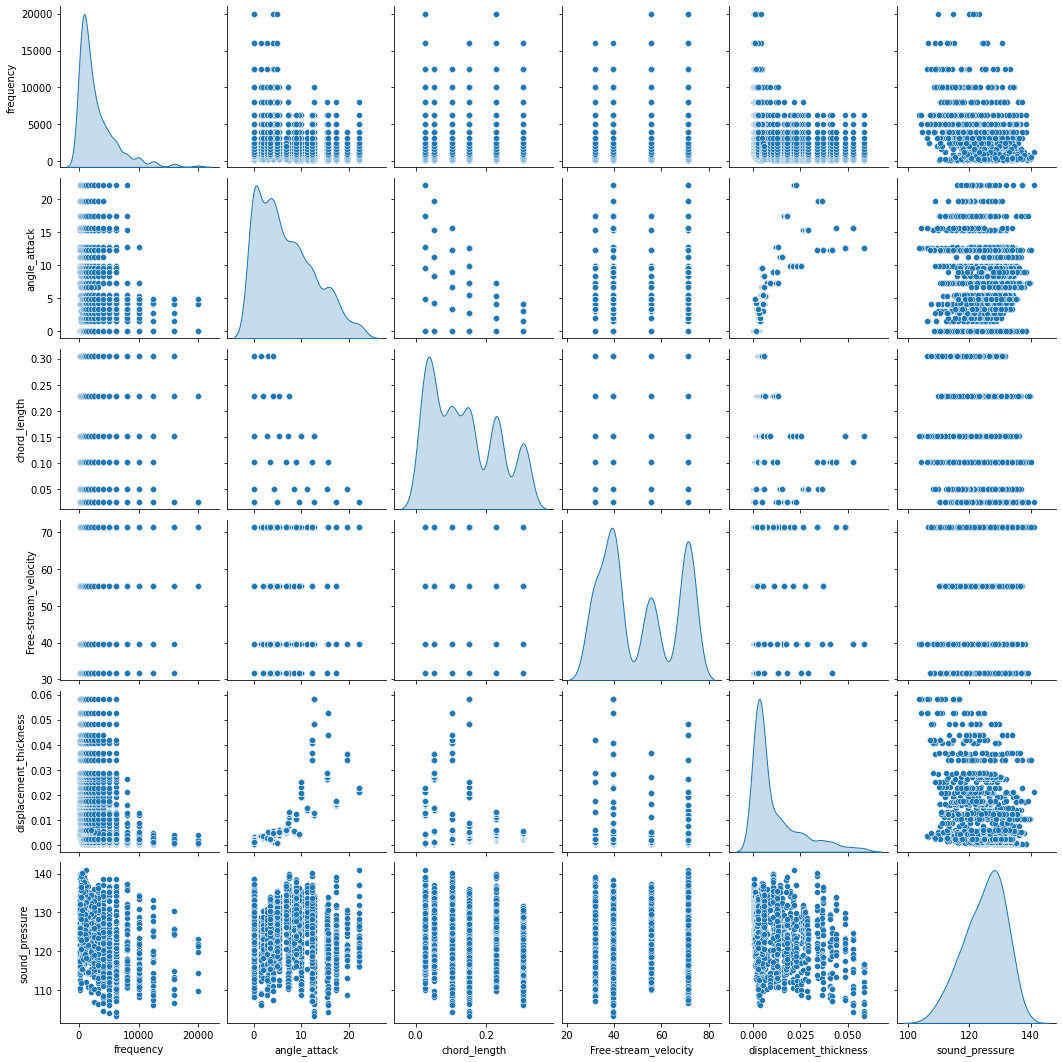

time: 14.7 s (started: 2021-12-03 09:11:11 +00:00)


In [13]:
sns.pairplot(data[['frequency', 'angle_attack','chord_length','Free-stream_velocity','displacement_thickness','sound_pressure']],diag_kind='kde')
sns.set(rc={'figure.figsize':(8,6)})

It is always a good exercise to look into the data visually and try to see the distributions of the features. 

### Identify nonnumerical values
Some ML algorithms can not handle non-numerical values (NaN: not a number) so you may need to identify the type of the data for each feature and modify it if necessary. It is also quite common that different feature values are missing for different instances / examples so you may need to decide what to do: (i) omit the instance; (ii) replace them with the mean / median / mode of the feature; (iv) substitute them with a value of your choice.

The following line counts the NaNs for each feature for us: 

In [14]:
nanCounter = np.isnan(data).sum()
print(nanCounter)

frequency                 0
angle_attack              0
chord_length              0
Free-stream_velocity      0
displacement_thickness    0
sound_pressure            0
dtype: int64
time: 4.06 ms (started: 2021-12-03 09:11:25 +00:00)


The data was entirely numerical and composed of numbers. We will see in the following sessions how to handle datasets including non-numerical features in a smart way!

It is also a good exercise to check the uniqueness of the dataset, that is, whether there exists values repeating at different instances:

In [15]:
distinctCounter = data.apply(lambda x: len(x.unique()))
print(distinctCounter)

frequency                   21
angle_attack                27
chord_length                 6
Free-stream_velocity         4
displacement_thickness     105
sound_pressure            1456
dtype: int64
time: 12.1 ms (started: 2021-12-03 09:11:25 +00:00)


As identified earlier, there are 1503 instances (experimental measurements). Here we realize that these experiments were planned as combinations of 5 input parameters, with unique values of 21x27x6x4x105. 

### Supervised Algorithms: Preparing the Labels

Supervised approach requires labelled data for the training. In this dataset, the objective function is the noise levels (classification) or noise prediction (regression), depending on the question. In both cases, we need to create a feature matrix say X and and label vector Y. We will use Y to train and test our model.

### Creating the Feature Matrix and Labels

In [16]:
dataX = data.copy().drop(['sound_pressure'],axis=1)
dataY = data['sound_pressure'].copy()

time: 8.98 ms (started: 2021-12-03 09:11:26 +00:00)


In [17]:
dataY.sample(5)

302     131.708
1056    127.008
1112    120.726
1311    133.649
875     131.515
Name: sound_pressure, dtype: float64

time: 10.2 ms (started: 2021-12-03 09:11:26 +00:00)


For more pre-processing options; you may check:

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing

### Data Normalization

In [18]:
#Rescaling the data
featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])
#Looking into the statistics again:
dataX.describe()

,frequency,angle_attack,chord_length,Free-stream_velocity,displacement_thickness
count,1.503000e+03,1.503000e+03,1.503000e+03,1.503000e+03,1.503000e+03
mean,2.837975e-16,-3.495393e-16,-1.624759e-14,-8.558246e-16,2.866045e-16
std,1.000333e+00,1.000333e+00,1.000333e+00,1.000333e+00,1.000333e+00
min,-8.524068e-01,-1.146403e+00,-1.188629e+00,-1.230809e+00,-8.169263e-01
25%,-6.620227e-01,-8.083458e-01,-9.169992e-01,-7.233448e-01,-6.545613e-01
50%,-4.081773e-01,-2.336486e-01,-3.737395e-01,-7.233448e-01,-4.702979e-01
75%,3.533590e-01,5.269801e-01,9.844097e-01,1.312935e+00,3.374462e-01
max,5.430267e+00,2.606032e+00,1.799299e+00,1.312935e+00,3.595917e+00


time: 72.5 ms (started: 2021-12-03 09:11:26 +00:00)


### Correlation matrix
Now let's try to visualize how correlated the data is by creating a correlation matrix. 

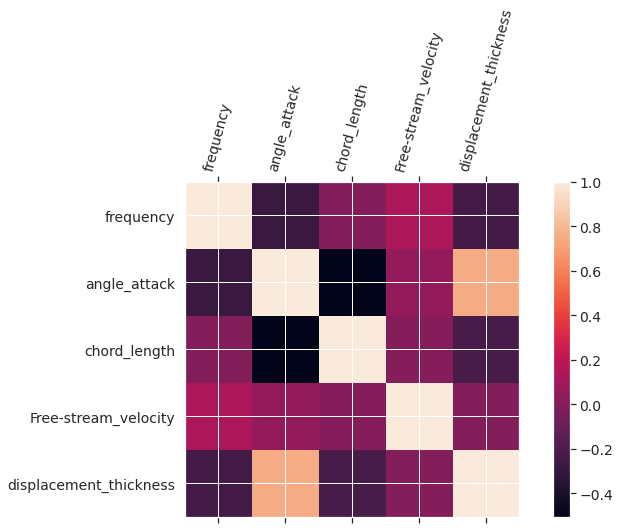

time: 271 ms (started: 2021-12-03 09:11:26 +00:00)


In [19]:
correlationMatrix = pd.DataFrame(dataX).corr() 

f = plt.figure(figsize=(12, 6))
plt.matshow(correlationMatrix, fignum=f.number)
plt.xticks(range(dataX.shape[1]), dataX.columns, fontsize=14, rotation=75)
plt.yticks(range(dataX.shape[1]), dataX.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()

In [20]:
#we can also simply look at the table via pandas:
correlationMatrix.style.background_gradient(cmap='viridis').set_precision(2)

,frequency,angle_attack,chord_length,Free-stream_velocity,displacement_thickness
frequency,1.00,-0.27,-0.00,0.13,-0.23
angle_attack,-0.27,1.00,-0.50,0.06,0.75
chord_length,-0.00,-0.50,1.00,0.00,-0.22
Free-stream_velocity,0.13,0.06,0.00,1.00,-0.00
displacement_thickness,-0.23,0.75,-0.22,-0.00,1.00


time: 84.4 ms (started: 2021-12-03 09:11:26 +00:00)


What do these numbers mean? 

When it is close to 1, it means that there is a strong positive correlation; At the other extreme; –1, it implies that there is a strong negative correlation. For more:

https://en.wikipedia.org/wiki/Correlation_and_dependence

## Preparing the Dataset for Model

We need to divide our entire dataset into fractions so that we have a training set
from which the machine learning algorithm learns. We also need another set to test the predictions of the ML algorithm. There is no golden rule here: you need to consider the size of your entire dataset. Sometimes 5% is more than enough, sometimes we need to divide 1/3 to have enough test samples. 

In our current examples, number of cases is quite low for a ML project. Therefore, lets leave sufficient number of test cases:





In [21]:
X_train, X_test, y_train, y_test = train_test_split(dataX,
dataY, test_size=0.20,
random_state=2020)

time: 5.12 ms (started: 2021-12-03 09:11:26 +00:00)


Here we have frozen the randomness to make the results reproducible. Otherwise, the results would change at every run. Notice that in classification, we divide the data in a way that labels are distributed in an unbiased way.

## Cross-Validation
Another rule of thumb is to split
the training set into a sub-training sets and a validation set before seeing its true performance on the test set (25% of the dataset reserved above). This policy is called k-fold cross-validation. The training data is divided into k fractions, trained over (k-1) fractions and tested on the k_th. Here the idea is to increase the generalization of the model as much as possible.

https://scikit-learn.org/stable/modules/cross_validation.html

In [22]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=2020)

time: 1.5 ms (started: 2021-12-03 09:11:26 +00:00)


# An Overview on MLP

A neural network revolves around the following objects:

*   Layers, which are combined into a network (or model)
*   The input data and corresponding targets
*   The loss function, which defines the feedback signal used for learning
*   The optimizer, which determines how learning proceeds

Therefore, in a typical architecture, the layers are linked together and map the input data to predictions. The loss function then compares these predictions to the targets, producing a loss value. This loss value is used as a measure on how well the network’s predictions match what was expected. The optimizer uses the loss value to update the network’s weights.

## Looking into Layers

You can think of layers as the LEGO bricks of deep learning, a typical metaphor. Each layer is a data-processing module that takes as input one / more tensors and then outputs one / more tensors.  Most layers have a state: the layer’s weights containing the network’s knowledge. 

Building deep-learning models in Tensor Flow TF (Keras) is
done by clipping together compatible layers to form useful data-transformation networks. Compatibility here refers to the fact that every layer will only accept input tensors of a certain shape and will return output tensors of a certain shape. In other words, different layers are needed for different data formats. For instance:

*  Simple vector data, stored in 2D tensors of shape (samples,features), is often processed by densely connected layers (the Dense class in Keras). 

*  Sequence data, stored in 3D tensors of shape (samples,
timesteps, features), is typically processed by recurrent layers such as an LSTM layer.

*  Image data, stored in 4D tensors, is usually processed by 2D convolution layers (Conv2D).


**You should never forget that** the topology of a network defines your **hypothesis space**. By choosing a network topology, you constrain your space of possibilities mapping input data to output data. This is commonly reffered as the "picking the right network architecture is more an art than a science". 

Note that each Dense layer manages its own weight matrix, containing all the connection weights between the neurons and their inputs. It also manages a vector of bias terms (one per neuron).

## Optimization Process

Choosing the right objective function for the right problem is extremely important: your network will take any shortcut it can, to minimize the loss. Fortunately, when it comes to common problems such as classification, regression, and sequence prediction, there are simple guidelines you can follow to choose the correct loss.

**Some starting points:**
* Binary cross-entropy for a two-class classification
problem, 
* Categorical cross-entropy for a many-class classification problem, 
* Meansquared error for a regression problem, 
* Connectionist temporal classification (CTC) for a sequence-learning problem.

## Creating the Model with Keras

Keras is a model-level library, providing high-level building blocks for developing deep-learning models. Via Tensor Flow, Keras is able to run seamlessly on both
CPUs and GPUs, which is an important advantage. 

A typical Keras workflow includes the following steps:

1. Define the training data: input tensors and target tensors.

2. Define a network of layers that maps the inputs to the targets.

3. Configure the learning process by choosing a loss function, an optimizer, and some metrics to monitor. 

4. Iterate on your training data by calling the `fit()` method of your model.

### Defining a Model: 
There are two ways to define a model: using the Sequential class (only for linear stacks of layers, which is the most common network architecture) or the functional API (which lets you build completely arbitrary architectures).

### Implementing into Tensor Flow:

Training a model with `tf.keras` starts by defining the model architecture.

Sequential model is implemented via `keras.Sequential`. This architecture is composed of a single stack of layers connected sequentially. 

Let's create an example and discuss over it:

We will first define our model:

`model = models.Sequential()`

Then add the layers one by one. 

`model.add(layers.Dense(32, activation='relu', input_shape=(128,)))`

Since this is the first layer, we’re passing the expected shape of the input data here. We also define the output format. Here the layer will return a tensor where the first dimension has been transformed to be 32 for the downstream layer.

`model.add(layers.Dense(16, activation='softmax'))`

The first layer can only be connected to a downstream layer that expects 32 dimensional vectors as its input. Nonetheless, we did not define input shape in the second layer. When using Keras, you don’t have to worry about
compatibility, because the layers you add to your models are dynamically built to match the shape of the incoming layer. 

## Learning Process

The learning process is configured in the **compilation** step, where you specify the **optimizer** and **loss function**(s) that the model should use, as well as the **metrics** you want to use in the training. 

`model.compile(optimizer=optimizers.RMSprop(lr=0.01), loss='mse', metrics=['accuracy'])`

In this example, we selected RMSprop as the optimizer with a given learning rate, defined a loss based on MSE and the metric is selected as accuracy.

The metrics argument should be a list -- your model can have any number of metrics. If your model has multiple outputs, you can specify different losses and metrics for each output, and you can modulate the contribution of each output to the total loss of the model. 

In general, you won't have to create from scratch your own losses, metrics, or optimizers, because what you need is likely already part of the Keras API.

**Optimizers:**

+ SGD() (with or without momentum),
+ RMSprop(),
+ Adam(), etc.

**Losses:**

+ MeanSquaredError(),
+ KLDivergence(),
+ CosineSimilarity(),etc.

**Metrics:**

+ AUC(),
+ Precision(),
+ Recall(), etc.

See other options from here:

https://keras.io/api/metrics/

https://keras.io/api/losses/

https://keras.io/api/optimizers/rmsprop/

Finally, we will pass the input data (and the
corresponding target data) to the model via the `fit()` method, similar to what we did in Scikit-Learn. 

`model.fit(input_tensor, target_tensor, batch_size=100, epochs=10)`

Here we will train the model by slicing the data into "batches" of size "batch_size", and repeatedly iterating over the entire dataset for a given number of "epochs".

https://keras.io/guides/training_with_built_in_methods/

# Working on the Regression Problem in TF

Lets remember the dataset first:

In [23]:
X_train.shape, X_test.shape

((1202, 5), (301, 5))

time: 4.09 ms (started: 2021-12-03 09:11:26 +00:00)


As you can see, we have 1202 training samples and 301 test samples, each with 5 numerical features.  The data is already normalized and ready for use. Otherwise, we would need to prepare the data first. 

## Building the NN for the Problem

Since we have limited number of samples for a NN application, it is better to use a small network. We can try to use two hidden layers, each with 64 units. 

In general, the less training data you have, the worse overfitting will be in a NN (it will memorize the data), and using a small network is one way to overcome overfitting.

In [24]:
# Creating the model
# If you are going to use the same model multiple times, it is more practical to use a function to construct it.

def build_model():
  #Here we will use Sequential API
  model = models.Sequential()
  #Defining the first hidden layer:
  #Note that we are using input_shape for the first layer.
  model.add(layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
  #Defining the second hidden layer:
  model.add(layers.Dense(32, activation='relu'))
  #Here we are defining the output layer. A single unit and no activation (it will be a linear layer).
  #Since this is a regression problem, we need to to predict a single continuous value. 
  #Applying an activation function would constrain the range the output can take; 
  #for instance, if you applied a sigmoid activation function to the last layer,
  #the network could only learn to predict values between 0 and 1 (good for binary classification).
  model.add(layers.Dense(1))
  #we will compile the network with the MSE loss function.
  #(we will look at the square of the difference between the predictions and the targets).
  # We will also monitor another metric during the training, that is the mean absolute error(MAE).
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model

time: 11.7 ms (started: 2021-12-03 09:11:26 +00:00)


In [25]:
#Looking into model structure:
build_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                192       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________
time: 224 ms (started: 2021-12-03 09:11:26 +00:00)


With the given structure, we have 1281 parameters to train for! Imagine how many parameters we would need in a very dense NN with many nodes!

In [26]:
#Model Training
#--------------------------------------------------------------------------
#Hyperparameters
num_epochs = 50
#The number of epochs determines the number of times the training occurs 
#over the entire dataset we pass into the neural network. 
batch_size = 10
#The batch sets the number of samples the neural network trains on before making the next gradient update. 
#If the batch is equal to the total number of observations, the neural network will make 
# a gradient update once every epoch. Otherwise, it will make updates multiple times per epoch.

time: 3.23 ms (started: 2021-12-03 09:11:26 +00:00)


In [27]:
#......................................
# k-fold implementation:
#......................................

# Model Training:
#-----------------------------------------------------------------------------
#Lists for storing scores
trainingScores = []
cvScores = []

#DataFrame is a 2-dimensional labeled data structure. You can think of it like a spreadsheet.
#Indexing in pandas means simply selecting particular rows and columns of data from a DataFrame.
#It is  also known as Subset Selection.
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index,columns=[0,1])

#kfold.split will generate indices to split data into training and test set (cv):
for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),y_train.ravel()):

  #'iloc' can be used when the user doesn’t know the index label:
  #Here we are filtering the data based on indices. Data is divided as 902/225.
  X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
  y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]

  #Fitting the model according to given data:
  #Into the fit method, we will pass in the input matrix X and the target y (labels).

  #Building the Keras model:
  model = build_model()

  #Training step: Trains the model in silent mode (verbose = 0)
  model.fit(X_train_fold, y_train_fold, epochs=num_epochs, batch_size=batch_size, verbose=0)

  #Evaluating the training pperformance:
  val_mse, val_mae = model.evaluate(X_train_fold, y_train_fold, verbose=0)
  trainingScores.append(val_mse)
  print('--------------------------------------------------------')
  print('Training MAE: ', val_mae)

  #Evaluating the CV pperformance:
  val_mse, val_mae = model.evaluate(X_cv_fold, y_cv_fold, verbose=0)
  cvScores.append(val_mse)
  print('CV MAE: ', val_mae)

#Lets see the overall score for the entire training set (1127)
####Modified###
val_mse_total, val_mae_total = model.evaluate(X_train, y_train, verbose=0)
print('--------------------------------------------------------')
print('MAE for the entire training dataset: ', val_mae_total)
print('--------------------------------------------------------')

--------------------------------------------------------
Training MAE:  3.184964895248413
CV MAE:  3.358576536178589
--------------------------------------------------------
Training MAE:  3.912116289138794
CV MAE:  3.661999464035034
--------------------------------------------------------
Training MAE:  3.624784469604492
CV MAE:  3.5726325511932373
--------------------------------------------------------
Training MAE:  3.288041830062866
CV MAE:  3.4244706630706787
--------------------------------------------------------
Training MAE:  3.5601134300231934
CV MAE:  3.923600435256958
--------------------------------------------------------
MAE for the entire training dataset:  3.632690668106079
--------------------------------------------------------
time: 41.8 s (started: 2021-12-03 09:11:26 +00:00)


In [28]:
cvScores

[18.50777816772461,
 23.335670471191406,
 22.967281341552734,
 18.869550704956055,
 25.21092987060547]

time: 9.04 ms (started: 2021-12-03 09:12:08 +00:00)


In [29]:
print('Mean CV score (MSE) is  %5.2f' %np.mean(cvScores))

Mean CV score (MSE) is  21.78
time: 2.27 ms (started: 2021-12-03 09:12:08 +00:00)


## Saving the history with increasing Epochs

In [30]:
#Model Training
#--------------------------------------------------------------------------
#Hyperparameters
num_epochs = 500
#The number of epochs determines the number of times the training occurs 
#over the entire dataset we pass into the neural network. 
batch_size = 10
#The batch sets the number of samples the neural network trains on before making the next gradient update. 
#If the batch is equal to the total number of observations, the neural network will make 
# a gradient update once every epoch. Otherwise, it will make updates multiple times per epoch.

time: 2.82 ms (started: 2021-12-03 09:12:08 +00:00)


In [31]:
#......................................
# k-fold implementation:
#......................................

# Model Training:
#-----------------------------------------------------------------------------

#DataFrame is a 2-dimensional labeled data structure. You can think of it like a spreadsheet.
#Indexing in pandas means simply selecting particular rows and columns of data from a DataFrame.
#It is  also known as Subset Selection.
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index,columns=[0,1])

#kfold.split will generate indices to split data into training and test set (cv):
for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),y_train.ravel()):

  #'iloc' can be used when the user doesn’t know the index label:
  #Here we are filtering the data based on indices. Data is divided as 902/225.
  X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
  y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]

  #Fitting the model according to given data:
  #Into the fit method, we will pass in the input matrix X and the target y (labels).

  #Building the Keras model:
  model = build_model()

  #Training step: Trains the model in silent mode (verbose = 0)
  ##----------Changed!----------##
  # Training and CV scores will be saved by the model on the history:
  history = model.fit(X_train_fold, y_train_fold, epochs=num_epochs, batch_size=batch_size, validation_data=(X_cv_fold, y_cv_fold) ,verbose=0)


time: 9min 4s (started: 2021-12-03 09:12:08 +00:00)


In [32]:
#Lets look into the history recorded:
hist = pd.DataFrame(history.history)
hist.sample(3)

,loss,mae,val_loss,val_mae
143,16.014708,3.032078,26.587414,4.238111
5,347.532928,15.290654,259.452148,13.553327
300,8.827243,2.268230,11.495160,2.531586


time: 17.5 ms (started: 2021-12-03 09:21:13 +00:00)


In [33]:
#Adding epoch column:
hist['epoch'] = history.epoch
# As you can see, we have the losses as well as mae for both training and CV data:
hist.sample(3)

,loss,mae,val_loss,val_mae,epoch
11,74.606804,6.838668,70.466011,6.976192,11
12,63.605839,6.358534,59.663284,6.288746,12
91,16.599358,3.079329,21.071007,3.519876,91


time: 21.5 ms (started: 2021-12-03 09:21:13 +00:00)


In [34]:
# Defining our function to see the evolution of error:
def plot_learning_curves(history):
  #We will omit the first 10 points for a better visualization:
  plt.plot(history['epoch'][10:],history['loss'][10:], "k--", linewidth=1.5, label="Training")
  plt.plot(history['epoch'][10:],history['val_loss'][10:], "b-.", linewidth=1.5, label="CV test")
  plt.legend()
  plt.ylim(1,100)
  plt.yscale("log")
  plt.xlabel("Epochs"),  plt.ylabel("MSE")

time: 7.49 ms (started: 2021-12-03 09:21:13 +00:00)


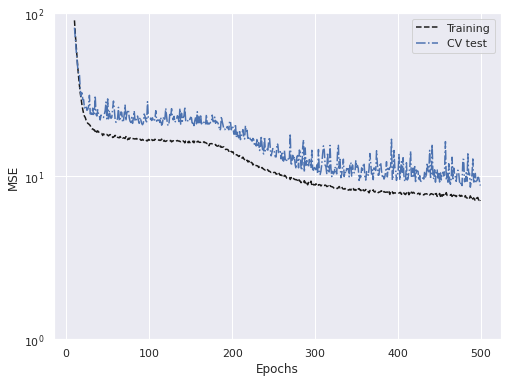

time: 989 ms (started: 2021-12-03 09:21:13 +00:00)


In [35]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves(hist)

We see that there is a noticable difference in the MSE between the training set and CV set; so we need to find a better arhitecture to improve model predictions.

## Checking the Predictive Accuracy on Test Data

Before fine-tuning our model, lets see the its current performance. For that purpose, we will investigate the variations between the predictions and the true values on scatter plots and histograms.

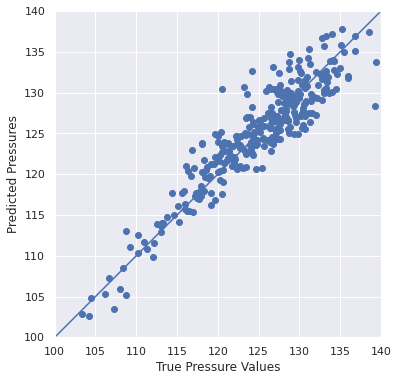

time: 489 ms (started: 2021-12-03 09:21:14 +00:00)


In [36]:
# Calling trained model for predictions:
Y_test_predictions = pd.Series(model.predict(X_test).flatten(),index=X_test.index)
#Visualization of the accuracy:
a = plt.axes(aspect='equal')
plt.scatter(y_test, Y_test_predictions)
plt.xlabel('True Pressure Values')
plt.ylabel('Predicted Pressures')
lims = [100, 140]
plt.xlim(lims), plt.ylim(lims)
plt.plot(lims, lims)

Text(0, 0.5, 'Count')

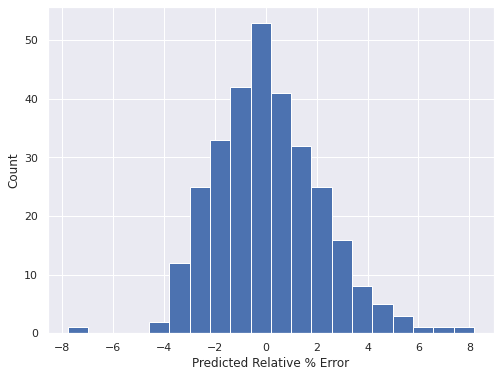

time: 397 ms (started: 2021-12-03 09:21:14 +00:00)


In [37]:
# Calculating the error variations:
error_nn = (Y_test_predictions - y_test)/y_test*100
plt.hist(error_nn, bins=20)
plt.xlabel('Predicted Relative % Error')
plt.ylabel('Count')

In [38]:
#Calculating the mean absolutepercentage error:
abs_error_nn = abs(Y_test_predictions - y_test)/y_test*100
np.average(error_nn)

0.10317187550943158

time: 8.07 ms (started: 2021-12-03 09:21:15 +00:00)


# Saving and Restoring a Model

Keras uses the HDF5 format to save both the model’s architecture (including every layer’s hyperparameters) and the values of all the model parameters for every layer.

Saving a trained Keras model is very simple:

In [39]:
model.save("my_MLP_model.h5")

time: 24.8 ms (started: 2021-12-03 09:21:15 +00:00)


Loading is very similar:


In [40]:
model = keras.models.load_model("my_MLP_model.h5")

time: 62 ms (started: 2021-12-03 09:21:15 +00:00)


# Fine-tuning NN Hyperparameters

We have made several decisions regarding to the NN architecture, how we compile and train the model. It is necessary to look at the influence of those decision on our predictions. 

We may investigate the following parameters:

*   Number of layers
*   Number of nodes
*   Activation function
*   Optimizer
*   Learning rate
*   Number of epochs 
*   Batch size to update the optimization

Other options we can include can be listed as:

*   Adding weight regularization
*   Adding dropout
*   Early stopping / Callback

**Note that** we are only looking at MLP; in principle, you can contruct an unlimited variety of computational graphs.
Here we will  only discuss the number of layers, the number of neurons per layer, the type of activation function to use in each layer, the weight initialization logic etc. 

**Hint I**

it’s often simpler and more efficient to pick a model with more layers and neurons than you actually need, then
use early stopping and other regularization techniques to prevent it from overfitting.

**Hint II**

Increasing the number of layers usually works better than increasing the number of neurons per layer, on the condition that number of neurons are not too few.

**Hint III**

if a layer has too few neurons, it will not have enough representational power to preserve all the useful information from the upstream layer.

**Hint IV**

When doing hyperparameter optimization, we are updating the hyperparameters based on a criteria that is computed using the validation data. Therefore, we are effectively training them on the validation data, and thus
they will quickly overfit to the validation data as well. Always keep in mind that over-hyper-parameterizing is also overfitting!

**Hint V**

Ensembling consists of pooling together the predictions of a set of different models, to produce better predictions. If you look at machine-learning competitions, for example on Kaggle, you’ll see that the winners typically use very large ensembles of
models, producing results better than single models. An option for you might be an ensemble of models, rather than a single architecture. An example for you: www.kaggle.com/c/higgs-boson

## Number of Neurons/ Nodes

FOr each problem,there is a balance to be found between too much complexity and little complexity.
Unfortunately, there is no rule of thumb here for finding the right number of layers / nodes.  

You may start, for instance, with relatively few layers and nodes, and increase the size of the layers or add new layers until you stop seeing improvement. As noted above, number of layers may yield better predictive accuracy for a fixed total number of nodes (again unless they are few). 

Lets look at the effect of number of neurons on the airfoil problem first:

In [41]:
#Our base model:
def build_model_base():
  #Here we will use Sequential API
  model = models.Sequential()
  model.add(layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
  model.add(layers.Dense(32, activation='relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model

def build_model_lower():
  #Here we will use Sequential API
  model = models.Sequential()
  model.add(layers.Dense(2, activation='relu', input_shape=(X_train.shape[1],)))
  model.add(layers.Dense(2, activation='relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model

def build_model_higher():
  #Here we will use Sequential API
  model = models.Sequential()
  model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model

time: 14.3 ms (started: 2021-12-03 09:21:15 +00:00)


In [42]:
#Model Training
#--------------------------------------------------------------------------
#Hyperparameters
num_epochs = 500
#The number of epochs determines the number of times the training occurs 
#over the entire dataset we pass into the neural network. 
batch_size = 10
#The batch sets the number of samples the neural network trains on before making the next gradient update. 
#If the batch is equal to the total number of observations, the neural network will make 
# a gradient update once every epoch. Otherwise, it will make updates multiple times per epoch.

time: 2.46 ms (started: 2021-12-03 09:21:15 +00:00)


In [43]:
#......................................
# k-fold implementation:
#......................................

# Model Training:
#-----------------------------------------------------------------------------

#DataFrame is a 2-dimensional labeled data structure. You can think of it like a spreadsheet.
#Indexing in pandas means simply selecting particular rows and columns of data from a DataFrame.
#It is  also known as Subset Selection.
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index,columns=[0,1])

#kfold.split will generate indices to split data into training and test set (cv):
for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),y_train.ravel()):

  #'iloc' can be used when the user doesn’t know the index label:
  #Here we are filtering the data based on indices. Data is divided as 902/225.
  X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
  y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]

  #Fitting the model according to given data:
  #Into the fit method, we will pass in the input matrix X and the target y (labels).

  #Building the Keras models:
  model_base = build_model_base()
  model_lower = build_model_lower()
  model_higher = build_model_higher()

  #Training step: Trains the model in silent mode (verbose = 0)
  ##----------Changed!----------##
  # Training and CV scores will be saved by the model on the history:
  history_base = model_base.fit(X_train_fold, y_train_fold, epochs=num_epochs, batch_size=batch_size, validation_data=(X_cv_fold, y_cv_fold) ,verbose=0)
  history_lower = model_lower.fit(X_train_fold, y_train_fold, epochs=num_epochs, batch_size=batch_size, validation_data=(X_cv_fold, y_cv_fold) ,verbose=0)
  history_higher = model_higher.fit(X_train_fold, y_train_fold, epochs=num_epochs, batch_size=batch_size, validation_data=(X_cv_fold, y_cv_fold) ,verbose=0)


time: 25min 35s (started: 2021-12-03 09:21:15 +00:00)


In [44]:
#Lets look into the history recorded:
hist_base = pd.DataFrame(history_base.history)
hist_base['epoch'] = history_base.epoch
hist_lower = pd.DataFrame(history_lower.history)
hist_lower['epoch'] = history_lower.epoch
hist_higher = pd.DataFrame(history_higher.history)
hist_higher['epoch'] = history_higher.epoch

time: 10.5 ms (started: 2021-12-03 09:46:51 +00:00)


### Plotting the results:

In [45]:
# Defining our function to see the evolution of error:
def plot_learning_curves_2(history1, history2, history3,parameter):
  #We will omit the first 10 points for a better visualization:
  plt.plot(history1['epoch'][10:],history1[parameter][10:], "k-", linewidth=2, label='Base '+parameter)
  plt.plot(history2['epoch'][10:],history2[parameter][10:], "b-.", linewidth=2, label='Lower '+parameter)
  plt.plot(history3['epoch'][10:],history3[parameter][10:], "r--", linewidth=2, label='Higher '+parameter)
  plt.legend()
  plt.ylim(1,1000)
  plt.yscale("log")
  plt.xlabel("Epochs"),  plt.ylabel("MSE")

time: 4.59 ms (started: 2021-12-03 09:46:51 +00:00)


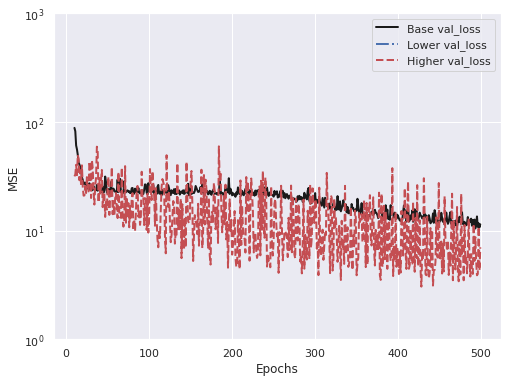

time: 581 ms (started: 2021-12-03 09:46:51 +00:00)


In [46]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves_2(hist_base,hist_lower,hist_higher,'val_loss')

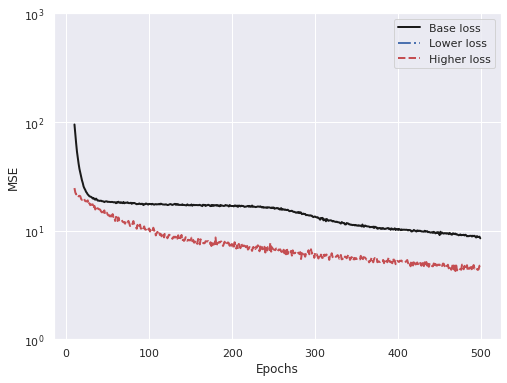

time: 574 ms (started: 2021-12-03 09:46:51 +00:00)


In [47]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves_2(hist_base,hist_lower,hist_higher,'loss')

## Number of Hidden Layers

Lets take the number of neurons as 16 and use different number of layers to see its effect.

In [48]:
#Our base model:
def build_model_base():
  #Here we will use Sequential API
  model = models.Sequential()
  model.add(layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)))
  model.add(layers.Dense(16, activation='relu'))
  model.add(layers.Dense(16, activation='relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model

def build_model_lower():
  #Here we will use Sequential API
  model = models.Sequential()
  model.add(layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)))
  model.add(layers.Dense(1))
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model

def build_model_higher():
  #Here we will use Sequential API
  model = models.Sequential()
  model.add(layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)))
  model.add(layers.Dense(16, activation='relu'))
  model.add(layers.Dense(16, activation='relu'))
  model.add(layers.Dense(16, activation='relu'))
  model.add(layers.Dense(16, activation='relu'))
  model.add(layers.Dense(16, activation='relu'))
  model.add(layers.Dense(16, activation='relu'))
  model.add(layers.Dense(16, activation='relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model

time: 28.1 ms (started: 2021-12-03 09:46:52 +00:00)


In [49]:
#Model Training
#--------------------------------------------------------------------------
#Hyperparameters
num_epochs = 500
batch_size = 10

time: 1.59 ms (started: 2021-12-03 09:46:52 +00:00)


In [50]:
#......................................
# k-fold implementation:
#......................................

# Model Training:
#-----------------------------------------------------------------------------

#DataFrame is a 2-dimensional labeled data structure. You can think of it like a spreadsheet.
#Indexing in pandas means simply selecting particular rows and columns of data from a DataFrame.
#It is  also known as Subset Selection.
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index,columns=[0,1])

#kfold.split will generate indices to split data into training and test set (cv):
for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),y_train.ravel()):

  #'iloc' can be used when the user doesn’t know the index label:
  #Here we are filtering the data based on indices. Data is divided as 902/225.
  X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
  y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]

  #Fitting the model according to given data:
  #Into the fit method, we will pass in the input matrix X and the target y (labels).

  #Building the Keras models:
  model_base = build_model_base()
  model_lower = build_model_lower()
  model_higher = build_model_higher()

  #Training step: Trains the model in silent mode (verbose = 0)
  ##----------Changed!----------##
  # Training and CV scores will be saved by the model on the history:
  history_base = model_base.fit(X_train_fold, y_train_fold, epochs=num_epochs, batch_size=batch_size, validation_data=(X_cv_fold, y_cv_fold) ,verbose=0)
  history_lower = model_lower.fit(X_train_fold, y_train_fold, epochs=num_epochs, batch_size=batch_size, validation_data=(X_cv_fold, y_cv_fold) ,verbose=0)
  history_higher = model_higher.fit(X_train_fold, y_train_fold, epochs=num_epochs, batch_size=batch_size, validation_data=(X_cv_fold, y_cv_fold) ,verbose=0)


time: 26min 33s (started: 2021-12-03 09:46:52 +00:00)


In [51]:
#Lets look into the history recorded:
hist_base = pd.DataFrame(history_base.history)
hist_base['epoch'] = history_base.epoch
hist_lower = pd.DataFrame(history_lower.history)
hist_lower['epoch'] = history_lower.epoch
hist_higher = pd.DataFrame(history_higher.history)
hist_higher['epoch'] = history_higher.epoch

time: 9.72 ms (started: 2021-12-03 10:13:26 +00:00)


### Plotting the results:

In [52]:
# Defining our function to see the evolution of error:
def plot_learning_curves_2(history1, history2, history3,parameter):
  #We will omit the first 10 points for a better visualization:
  plt.plot(history1['epoch'][10:],history1[parameter][10:], "k-", linewidth=2, label='Base '+parameter)
  plt.plot(history2['epoch'][10:],history2[parameter][10:], "b-.", linewidth=2, label='Lower '+parameter)
  plt.plot(history3['epoch'][10:],history3[parameter][10:], "r--", linewidth=2, label='Higher '+parameter)
  plt.legend()
  plt.ylim(1,100)
  plt.yscale("log")
  plt.xlabel("Epochs"),  plt.ylabel("MSE")

time: 7.05 ms (started: 2021-12-03 10:13:26 +00:00)


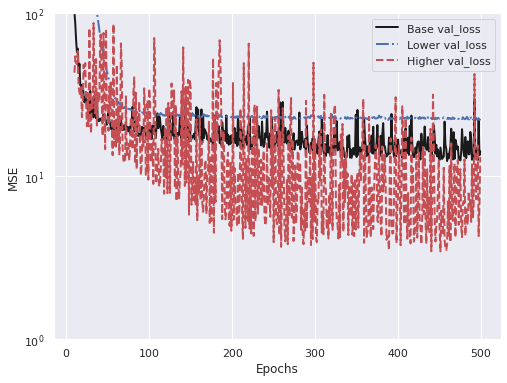

time: 532 ms (started: 2021-12-03 10:13:26 +00:00)


In [53]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves_2(hist_base,hist_lower,hist_higher,'val_loss')

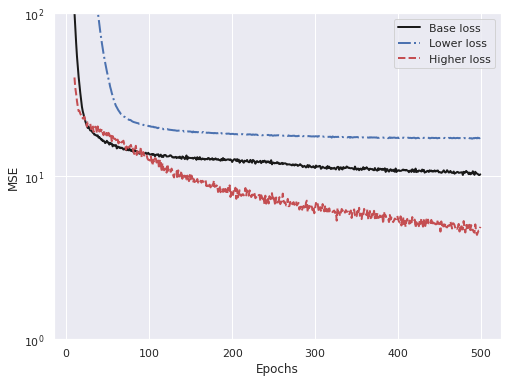

time: 519 ms (started: 2021-12-03 10:13:26 +00:00)


In [54]:
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
plot_learning_curves_2(hist_base,hist_lower,hist_higher,'loss')

## Callbacks

A callback is an object that is passed to the model in the call to fit and  called by the model at various points during training. It has access to all the available data about the state of the model and its performance, and it can take action: (i) interrupt training, (ii) save a model, (iii) load a different
weight set, (iv) otherwise alter the state of the model.

Here are some practical examples: 
* **Model checkpointing—Saving:** the current weights of the model at different points during training.

* **Early stopping / Interrupting:** when the validation loss is no longer improving, stops the training procedure(saving the best model obtained during training).

* **Dynamically adjusting** the learning rate of the optimizer.

* **Logging** training and validation metrics during training, or **visualizing** the representations learned by the model as they’re updated.


The keras.callbacks module includes a number of built-in callbacks:
* `keras.callbacks.ModelCheckpoint`
* `keras.callbacks.EarlyStopping`
* `keras.callbacks.LearningRateScheduler`
* `keras.callbacks.ReduceLROnPlateau`
* `keras.callbacks.CSVLogger`

see https://keras.io/api/callbacks/ for more!

### Callback implementation: ModelCheckpoint & Early Stopping

The `fit()` method accepts the callbacks argument that lets you specify a list of objects. These objects are called at the start and end of training or even before and after processing each batch. 

If you feed the CV data in `fit()`, you can set
`save_best_only=True` when creating the `ModelCheckpoint`. In this case, it will only
save your model when its performance on the validation set is the best so far. This is a measure for **overfitting**.  

In [55]:
#We will first create the object to feed fit() method:
myCheckpoint= keras.callbacks.ModelCheckpoint("my_best_model.h5", save_best_only=True)

time: 1.57 ms (started: 2021-12-03 10:13:27 +00:00)


We can combine it with `EarlyStopping` as well. Lets create another object. By doing so, we will interrupt training early when there is no more progress.

In [56]:
#For its implementation:
#https://keras.io/api/callbacks/early_stopping/
# Here patience refers to the number of epochs with no improvement after which training will be stopped.
myEarly_stopping = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

time: 3.55 ms (started: 2021-12-03 10:13:27 +00:00)


In [57]:
#Model Training
#--------------------------------------------------------------------------
#Hyperparameters
num_epochs = 100
batch_size = 10

time: 9 ms (started: 2021-12-03 10:13:27 +00:00)


In [58]:
#......................................
# k-fold implementation:
#......................................

# Model Training:
#-----------------------------------------------------------------------------

#DataFrame is a 2-dimensional labeled data structure. You can think of it like a spreadsheet.
#Indexing in pandas means simply selecting particular rows and columns of data from a DataFrame.
#It is  also known as Subset Selection.
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index,columns=[0,1])

#kfold.split will generate indices to split data into training and test set (cv):
for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),y_train.ravel()):

  #'iloc' can be used when the user doesn’t know the index label:
  #Here we are filtering the data based on indices. Data is divided as 902/225.
  X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
  y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]

  #Fitting the model according to given data:
  #Into the fit method, we will pass in the input matrix X and the target y (labels).

  #Building the Keras models:
  model_base = build_model_base()

  #Training step: Trains the model in silent mode (verbose = 0)
  ##----------Changed!----------##
  # Training and CV scores will be saved by the model on the history:
  history_base = model_base.fit(X_train_fold, y_train_fold, epochs=num_epochs, batch_size=batch_size, validation_data=(X_cv_fold, y_cv_fold) , 
                                callbacks=[myCheckpoint,myEarly_stopping], verbose=0)

#Calling back the best model:
model_best = keras.models.load_model("my_best_model.h5")


time: 1min 20s (started: 2021-12-03 10:13:27 +00:00)


### Testing the model accuracy:

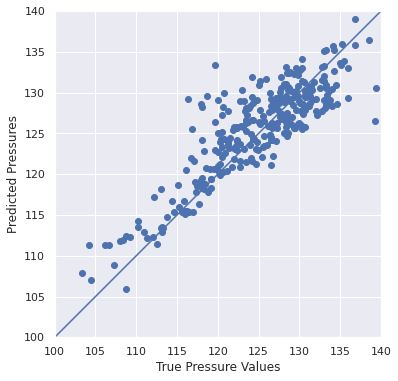

time: 455 ms (started: 2021-12-03 10:14:47 +00:00)


In [59]:
# Calling trained model for predictions:
Y_test_predictions = pd.Series(model_best.predict(X_test).flatten(),index=X_test.index)
#Visualization of the accuracy:
a = plt.axes(aspect='equal')
plt.scatter(y_test, Y_test_predictions)
plt.xlabel('True Pressure Values')
plt.ylabel('Predicted Pressures')
lims = [100, 140]
plt.xlim(lims), plt.ylim(lims)
plt.plot(lims, lims)

Text(0, 0.5, 'Count')

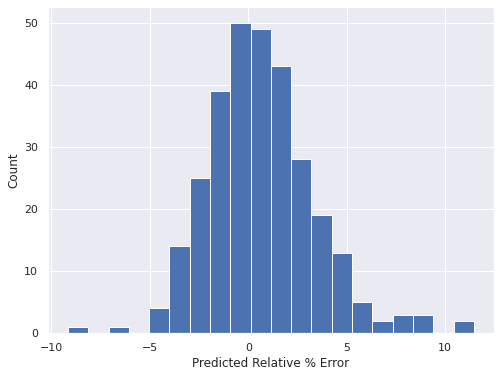

time: 352 ms (started: 2021-12-03 10:14:48 +00:00)


In [60]:
# Calculating the error variations:
error_nn = (Y_test_predictions - y_test)/y_test*100
plt.hist(error_nn, bins=20)
plt.xlabel('Predicted Relative % Error')
plt.ylabel('Count')

In [61]:
#Calculating the mean absolutepercentage error:
abs_error_nn = abs(Y_test_predictions - y_test)/y_test*100
np.average(error_nn)

0.6588522847183327

time: 6.83 ms (started: 2021-12-03 10:14:48 +00:00)


## Weight Regularization

You are already familiar with regularization from our regression lecture (if needed please see lecture notes). 

In NN, we control the complexity of the network by forcing the weights to take small values. This is called weight regularization, The idea is very simple: we introduce an additional cost associated with having large weights (similar to what we did in scikit learn):

+ L1 regularization: The cost added is proportional to the absolute value of the weight coefficients (the L1 norm of the weights).

+ L2 regularization: The cost added is proportional to the square of the value of the weight coefficients (the L2 norm of the weights). 

Remember what we discussed in the regression lecture: the L2 regularization is also called weight decay. 

It is very easy to apply regularization with `Keras`. We simply add weight regularization via weight regularizer instances to layers as keyword arguments:

These layers expose 3 keyword arguments:

+ kernel_regularizer: Regularizer to apply a penalty on the layer's kernel
+ bias_regularizer: Regularizer to apply a penalty on the layer's bias
+ activity_regularizer: Regularizer to apply a penalty on the layer's output

see https://keras.io/api/layers/regularizers/ for more!

In [62]:
#Our base model:
# Note that l2(0.001) means every coefficient in the weight matrix of the layer will add
# (0.001 * weight_coefficient_value) to the total loss of the network.
# The default value is l2=0.01.
def build_model_base_reg():
  #Here we will use Sequential API
  model = models.Sequential()
  model.add(layers.Dense(16,  kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(X_train.shape[1],)))
  model.add(layers.Dense(16,  kernel_regularizer=regularizers.l2(0.001), activation='relu'))
  model.add(layers.Dense(16,  kernel_regularizer=regularizers.l2(0.001), activation='relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model

time: 8.9 ms (started: 2021-12-03 10:14:48 +00:00)


In [63]:
#Model Training
#--------------------------------------------------------------------------
#Hyperparameters
num_epochs = 100
batch_size = 10

time: 1.8 ms (started: 2021-12-03 10:14:48 +00:00)


In [64]:
#......................................
# k-fold implementation:
#......................................

# Model Training:
#-----------------------------------------------------------------------------

#DataFrame is a 2-dimensional labeled data structure. You can think of it like a spreadsheet.
#Indexing in pandas means simply selecting particular rows and columns of data from a DataFrame.
#It is  also known as Subset Selection.
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index,columns=[0,1])

#kfold.split will generate indices to split data into training and test set (cv):
for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),y_train.ravel()):

  #'iloc' can be used when the user doesn’t know the index label:
  #Here we are filtering the data based on indices. Data is divided as 902/225.
  X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
  y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]

  #Fitting the model according to given data:
  #Into the fit method, we will pass in the input matrix X and the target y (labels).

  #Building the Keras models:
  model_base = build_model_base_reg()

  #Training step: Trains the model in silent mode (verbose = 0)
  ##----------Changed!----------##
  # Training and CV scores will be saved by the model on the history:
  history_base = model_base.fit(X_train_fold, y_train_fold, epochs=num_epochs, batch_size=batch_size, validation_data=(X_cv_fold, y_cv_fold) , 
                                callbacks=[myCheckpoint,myEarly_stopping], verbose=0)

#Calling back the best model:
model_best = keras.models.load_model("my_best_model.h5")


time: 1min 3s (started: 2021-12-03 10:14:48 +00:00)


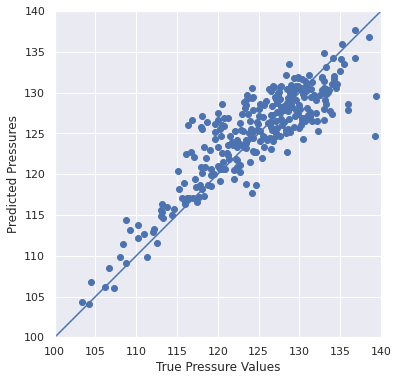

time: 468 ms (started: 2021-12-03 10:15:52 +00:00)


In [65]:
# Calling trained model for predictions:
Y_test_predictions = pd.Series(model_best.predict(X_test).flatten(),index=X_test.index)
#Visualization of the accuracy:
a = plt.axes(aspect='equal')
plt.scatter(y_test, Y_test_predictions)
plt.xlabel('True Pressure Values')
plt.ylabel('Predicted Pressures')
lims = [100, 140]
plt.xlim(lims), plt.ylim(lims)
plt.plot(lims, lims)

Text(0, 0.5, 'Count')

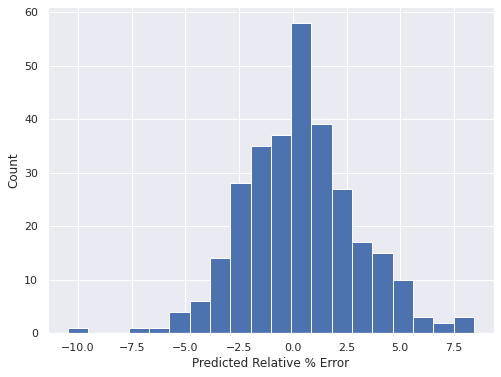

time: 382 ms (started: 2021-12-03 10:15:52 +00:00)


In [66]:
# Calculating the error variations:
error_nn = (Y_test_predictions - y_test)/y_test*100
plt.hist(error_nn, bins=20)
plt.xlabel('Predicted Relative % Error')
plt.ylabel('Count')

In [67]:
#Calculating the mean absolutepercentage error:
abs_error_nn = abs(Y_test_predictions - y_test)/y_test*100
np.average(error_nn)

0.33085367457601716

time: 8.49 ms (started: 2021-12-03 10:15:53 +00:00)


## Dropout

This method is one the key ideas that you should remember from this lecture. It is one of the most effective and most commonly used regularization techniques for neural networks. 

Dropout strategy relies on randomly dropping out (setting to zero) a number of output features of the layer during training. 

Lets imagine an example. Let’s say that layer number X gives a vector of weights `[0.08, 0.16, 5.2, 4.1, 0.21, 4.51, 0.78]` during the training. After applying dropout, some elements will be down to zero randomly: 

`[0.08, 0, 5.2, 0, 0.21, 4.51, 0]`

Dropout rate is controlled by a fraction value, typically taken between 0.2 and 0.5.

In TF Keras, we add a Dropout layer that is applied to the output of the layer just before:

`model.add(layers.Dropout(0.3))`



In [68]:
#Our base model:
# Note that l2(0.001) means every coefficient in the weight matrix of the layer will add
# (0.001 * weight_coefficient_value) to the total loss of the network.
# The default value is l2=0.01.
def build_model_base_reg():
  #Here we will use Sequential API
  model = models.Sequential()
  model.add(layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(32, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(32, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(1))
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model

time: 10.4 ms (started: 2021-12-03 10:15:53 +00:00)


In [69]:
#Model Training
#--------------------------------------------------------------------------
#Hyperparameters
num_epochs = 100
batch_size = 10

time: 1.73 ms (started: 2021-12-03 10:15:53 +00:00)


In [70]:
#......................................
# k-fold implementation:
#......................................

# Model Training:
#-----------------------------------------------------------------------------

#DataFrame is a 2-dimensional labeled data structure. You can think of it like a spreadsheet.
#Indexing in pandas means simply selecting particular rows and columns of data from a DataFrame.
#It is  also known as Subset Selection.
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index,columns=[0,1])

#kfold.split will generate indices to split data into training and test set (cv):
for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),y_train.ravel()):

  #'iloc' can be used when the user doesn’t know the index label:
  #Here we are filtering the data based on indices. Data is divided as 902/225.
  X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
  y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]

  #Fitting the model according to given data:
  #Into the fit method, we will pass in the input matrix X and the target y (labels).

  #Building the Keras models:
  model_base = build_model_base_reg()

  #Training step: Trains the model in silent mode (verbose = 0)
  ##----------Changed!----------##
  # Training and CV scores will be saved by the model on the history:
  history_base = model_base.fit(X_train_fold, y_train_fold, epochs=num_epochs, batch_size=batch_size, validation_data=(X_cv_fold, y_cv_fold) , 
                                callbacks=[myCheckpoint,myEarly_stopping], verbose=0)

#Calling back the best model:
model_best = keras.models.load_model("my_best_model.h5")


time: 50.9 s (started: 2021-12-03 10:15:53 +00:00)


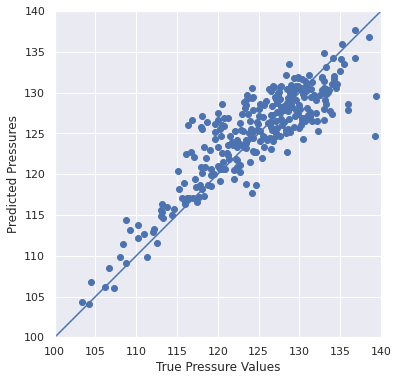

time: 457 ms (started: 2021-12-03 10:16:44 +00:00)


In [71]:
# Calling trained model for predictions:
Y_test_predictions = pd.Series(model_best.predict(X_test).flatten(),index=X_test.index)
#Visualization of the accuracy:
a = plt.axes(aspect='equal')
plt.scatter(y_test, Y_test_predictions)
plt.xlabel('True Pressure Values')
plt.ylabel('Predicted Pressures')
lims = [100, 140]
plt.xlim(lims), plt.ylim(lims)
plt.plot(lims, lims)

Text(0, 0.5, 'Count')

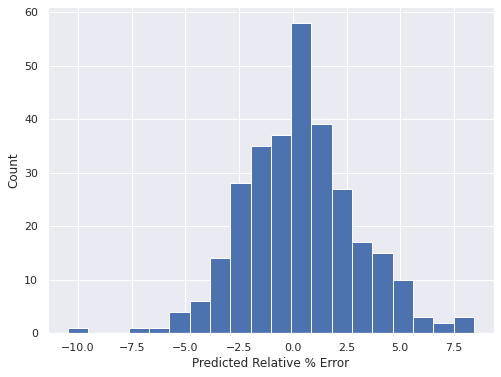

time: 377 ms (started: 2021-12-03 10:16:44 +00:00)


In [72]:
# Calculating the error variations:
error_nn = (Y_test_predictions - y_test)/y_test*100
plt.hist(error_nn, bins=20)
plt.xlabel('Predicted Relative % Error')
plt.ylabel('Count')

In [73]:
#Calculating the mean absolutepercentage error:
abs_error_nn = abs(Y_test_predictions - y_test)/y_test*100
np.average(error_nn)

0.33085367457601716

time: 6.17 ms (started: 2021-12-03 10:16:45 +00:00)


## Activation Functions

Activations can either be used through an activation layer, or through the activation argument. For instance:

``model.add(layers.Dense(64, activation=activations.relu))``

All built-in activations may also be passed via their string identifier:

``model.add(layers.Dense(64, activation='relu'))``


There are different acctivation functions available in Keras:

+ **ReLU**: Applies the rectified linear unit activation function.

+ **LeakyReLU**: Leaky version of a Rectified Linear Unit. It allows a small gradient when the unit is not active.

+ **sigmoid**: Applies the sigmoid activation function.

+ **Softmax**: Softmax converts a real vector to a vector of categorical probabilities. The elements of the output vector are in range (0, 1) and sum to 1.

+ **softplus**: softplus(x) = log(exp(x) + 1).

+ **softsign**: softsign(x) = x / (abs(x) + 1).

+ **tanh**: Hyperbolic tangent activation function.

+ **exponential**: Exponential activation function.

+ **elu**: The exponential linear unit (ELU) with alpha > 0 is: 

  x if x > 0 and 
  alpha * (exp(x) - 1) if x < 0 
  
  The ELU hyperparameter alpha controls the value to which an ELU saturates for negative net inputs. ELUs diminish the vanishing gradient effect.

+ **selu**: Scaled Exponential Linear Unit (SELU) activation function;

  if x > 0: return scale * x

  if x < 0: return scale * alpha * (exp(x) - 1)

  where alpha and scale are pre-defined constants (alpha=1.67326324 and scale=1.05070098).



## Vanishing/Exploding Gradients: How can we alleviate?

One common problem in deep learning is the vanishing gradients. 

During the training,  the gradients often get smaller and smaller as the algorithm progresses down to the lower layers. As a result, the weights of the lower layers do not get updated anymore. As a result, training may not be converged to a good solution / no convergence at all. This is called the vanishing gradients problem. The opposite may also be observed (eg. RNN), where the gradients go to very large values and the solution diverges (explodes). 

The reasons were not that clear at the early days of ML. It has been shown in the last decade that it is strongly related to the initialization of the weights and the selection of activation functions (synergetic effects also observed). Therefore we need smart ways to initialize our network. This, in fact, is not a big suprise if you look at ML as an optimization problem. In this section, we will look alternative ways to implement it in Tensor Flow via Keras.

### Glorot Initialization

Glorot and Bengio proposed a method to maintain the gradients to have equal variance before and after
flowing through a layer in the reverse direction, where the connection weights of each layer are initialized randomly. You may find their work here (cited ~11,000 times):

http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf?hc_location=ufi

Glorot initialization speeds up training significantly and it is one of the core reasons for the success of ML.

The keyword arguments used for passing initializers to layers depends on the layer. Usually, it is simply `kernel_initializer` and `bias_initializer`:

`kernel_initializer=initializers.RandomNormal(stddev=0.01)`

In dense layer, `glorot_uniform`, in fact, is the [default](https://github.com/fchollet/keras/blob/62d097c4ff6fa694a4dbc670e9c7eb9e2bc27c74/keras/layers/core.py#L798) option in Keras:

```
class Dense(Layer):
...
    def __init__(self, units,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
```
So, this is already valid in our previous calculations.  

Keras documentation, see:

https://faroit.com/keras-docs/2.0.6/initializers/

https://keras.io/api/layers/initializers/

### He Initialization
It is the initialization strategy for the `ReLU` activation function. 

If you are using the ReLU activation function and would like to use He initialization, you can change the default option via:

``kernel_initializer="he_uniform"`` 

https://faroit.com/keras-docs/2.0.6/initializers/#he_uniform

or: 

``kernel_initializer="he_normal":``

https://faroit.com/keras-docs/2.0.6/initializers/#he_normal

in the dense layer:

``keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")``

You can change the above code to see its impact!

### Activation Function Affects GD

The rectified linear activation function (ReLU) is a piecewise linear function that will output the input directly if it is positive, otherwise, it will always gives zero. Despite its simple form, It has become a popular activation function as (i) it is easier to train and (ii) often achieves good performance. 

(*Fun fact: early researchers mimic the nature and used sigmoid functions in NN, which leaded to problems in GD algorithms.*)

Nontheless, ReLu is not perfect and many neurons "die" during the training if ReLu is used. they gives nothing but zero and you will end up many nodes that has no effect on GD (gradient of the ReLU function is zero when its input is negative). This becomes more critical with large learning rates. To overcome this issue, you may use the **leaky ReLU, ELU or SELU**.

You may see how the function looks like here:
https://en.wikipedia.org/wiki/Rectifier_(neural_networks)

**Hint:** ReLU is the most widely used method, mainly due to its speed.

**Hint:** It is dangerous to make such comments but if you ask anyways, predictive capabilities follows:

general SELU > ELU > leaky ReLU (and derivatives) > ReLU > tanh > logistic.

For leaky ReLU, you need to another line after the dense layer:

```
...
keras.layers.Dense(10, kernel_initializer="he_normal"),
keras.layers.LeakyReLU(alpha=0.1),
...
```


**Hint:** ELU activation function is much slower than the ReLU function and its variants.

**Hint:** SELU activation function often outperforms others. But you need to be careful in its implementation:

  + The input features must be standardized ( mean =0; SD = 1).
  + Every hidden dense layer must be initialized with LeCun normal initialization 
  
  `layer = keras.layers.Dense(10, activation="selu",
kernel_initializer="lecun_normal")`

  + The architecture must be sequential (not suitable for RNN).

### Batch Normalization

Lets say that you have picked the right initialization with the right activation function: `selu` or `LeakyReLU`. This will help you to initialize your network properly. Unfortunately, GD issues may still be observed in the later stages of the training. 

Batch normalization is a type of layer(`BatchNormalization`) introduced
in 2015 by Ioffe and Szegedy to overcome this issue:

https://arxiv.org/abs/1502.03167

It can adaptively normalize data even as the mean and variance change over time -- that is during the training. It works by internally maintaining an exponential moving average of the batch-wise mean and variance of the data seen during training. See the paper to fully understand how it works.

From a 'cooking class' point of view. the main effect of batch normalization is that it helps us with gradient propagation as we train the network, hence **allows for deeper networks with less GD issues!.**

You can implement it in a layer with the following command:

`model.add(layers.BatchNormalization())`

You should add the above line before / after defining the layer.

***

Note that there is even a newer version of the batch normalization, maybe implemented in TF soon. For more recent developments, if interested, you may check the following papers:

* Sergey Ioffe, “Batch Renormalization: Towards Reducing Minibatch Dependence in BatchNormalized Models” (2017), https://arxiv.org/abs/1702.03275.

* Günter Klambauer et al., “Self-Normalizing Neural Networks,” Conference on Neural Information Processing Systems (2017), https://arxiv.org/abs/1706.02515.



In [74]:
# Lets show it over a similar network:

def build_model_batch():
  #Here we will use Sequential API
  model = models.Sequential([
                             
  layers.Dense(32, activation="elu", kernel_initializer="he_normal", input_shape=(X_train.shape[1],)),                           
  layers.BatchNormalization(),layers.Dropout(0.5),
  layers.Dense(32, kernel_initializer="he_normal"),keras.layers.LeakyReLU(alpha=0.1),
  layers.BatchNormalization(),layers.Dropout(0.5),
  layers.Dense(32, activation="elu", kernel_initializer="he_normal"),
  layers.BatchNormalization(),layers.Dropout(0.5),
  layers.Dense(1)
  ])
  
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model


time: 12.1 ms (started: 2021-12-03 10:16:45 +00:00)


In [75]:
#Model Training
#--------------------------------------------------------------------------
#Hyperparameters
num_epochs = 100
batch_size = 10

time: 1.99 ms (started: 2021-12-03 10:16:45 +00:00)


In [76]:
#......................................
# k-fold implementation:
#......................................

# Model Training:
#-----------------------------------------------------------------------------

#DataFrame is a 2-dimensional labeled data structure. You can think of it like a spreadsheet.
#Indexing in pandas means simply selecting particular rows and columns of data from a DataFrame.
#It is  also known as Subset Selection.
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index,columns=[0,1])

#kfold.split will generate indices to split data into training and test set (cv):
for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),y_train.ravel()):

  #'iloc' can be used when the user doesn’t know the index label:
  #Here we are filtering the data based on indices. Data is divided as 902/225.
  X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
  y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]

  #Fitting the model according to given data:
  #Into the fit method, we will pass in the input matrix X and the target y (labels).

  #Building the Keras models:
  model_base = build_model_batch()

  #Training step: Trains the model in silent mode (verbose = 0)
  ##----------Changed!----------##
  # Training and CV scores will be saved by the model on the history:
  history_base = model_base.fit(X_train_fold, y_train_fold, epochs=num_epochs, batch_size=batch_size, validation_data=(X_cv_fold, y_cv_fold) , 
                                callbacks=[myCheckpoint,myEarly_stopping], verbose=0)

#Calling back the best model:
model_best = keras.models.load_model("my_best_model.h5")


time: 1min 9s (started: 2021-12-03 10:16:45 +00:00)


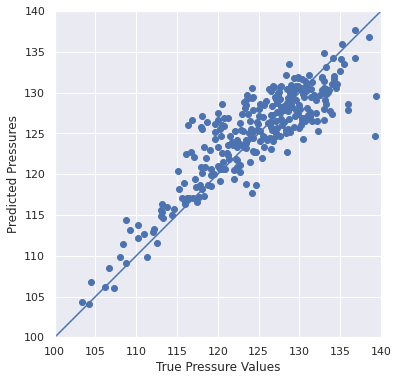

time: 481 ms (started: 2021-12-03 10:17:54 +00:00)


In [77]:
# Calling trained model for predictions:
Y_test_predictions = pd.Series(model_best.predict(X_test).flatten(),index=X_test.index)
#Visualization of the accuracy:
a = plt.axes(aspect='equal')
plt.scatter(y_test, Y_test_predictions)
plt.xlabel('True Pressure Values')
plt.ylabel('Predicted Pressures')
lims = [100, 140]
plt.xlim(lims), plt.ylim(lims)
plt.plot(lims, lims)

Text(0, 0.5, 'Count')

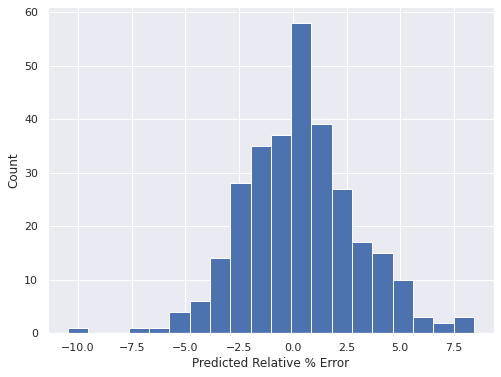

time: 402 ms (started: 2021-12-03 10:17:54 +00:00)


In [78]:
# Calculating the error variations:
error_nn = (Y_test_predictions - y_test)/y_test*100
plt.hist(error_nn, bins=20)
plt.xlabel('Predicted Relative % Error')
plt.ylabel('Count')

In [79]:
#Calculating the mean absolutepercentage error:
abs_error_nn = abs(Y_test_predictions - y_test)/y_test*100
np.average(error_nn)

0.33085367457601716

time: 6.39 ms (started: 2021-12-03 10:17:55 +00:00)


## Optimizers

Optimizer is one of the two arguments required for compiling a NN graph via Keras. In the previous examples, we used RMSProp as the optmizer but we have other options to use in TF. 

The reason why we did not use traditional GD even in the examples is it is much slower than the other alternatives. In this section, we will see a few alternatives to be used as fast optimizers.

**Reminder:**

To add an optimizer, you can either instantiate it before passing it to model.compile():
```
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy',optimizer=opt)
```

or you can pass it by its string identifier, as we did before:
```
model.compile(loss='categorical_crossentropy', optimizer='adam')
```



### Improved GD: Gradient descent with momentum optimizer

This is a relatively old but smart idea: integration of terminal velocity concept into GD. In GD, we follow the gradient with regular steps down the slope. With momentum optimizer, it will accelerate as it "falls" and reach a "terminal velocity".

Its implentation in Keras is very simple. We just define the momentum parameter when we implement SGD:

``optimizer = optimizers.SGD(lr=0.001, momentum=0.9)``

Default momentum rate is zero. Note that if you add ``nesterov=True``, it will use an updated version. See https://keras.io/api/optimizers/sgd/ for more information.

You may test it by changing the code above!

### RMSProp algorithm

This is the algortihm we used so far. The method was [introduced](https://homl.info/57) in 2012. 

Default Keras settings are given as [follows](https://keras.io/api/optimizers/rmsprop/):

```
tf.keras.optimizers.RMSprop(
    learning_rate=0.001,
    rho=0.9,
    momentum=0.0,
    epsilon=1e-07,
    centered=False,
    name="RMSprop",
    **kwargs
)
```

In Keras, RMSprop uses plain momentum and acuumulates the the gradients from the most recent iterations (controlled by rho). If interested, there is even a [lecture](https://www.youtube.com/watch?v=defQQqkXEfE). You can check for more details. 

### and Adam says "Why not both?"

Adaptive moment estimation (ADAM) combines the ideas of momentum optimization and RMSProp. It is the most popular option for many DNN problems. 

Original work can be found in here: http://arxiv.org/abs/1412.6980

In Keras, default settings are as follows:

```
tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam",
    **kwargs
)
```
Here ``beta_1`` is the momentum decay hyperparameter and ``beta_2`` is the scaling decay hyperparameter. Epsilon is the smoothing term. 

In short, it keep tracks of exponentially decaying average of both past gradients and past squared gradients (can you see the similarities in the line of thoughts with elastic net?). 

**Note:** Nadam optimization =  Adam optimization + Nesterov. 
It may help to converge faster:

https://keras.io/api/optimizers/Nadam/ 


### Important Reminder

These improvements are useful (converges fast) and accurate for many test cases, yet that is not always the case. 

"Adaptive optimization methods, which perform local optimization with a metric constructed from the history of iterates, are becoming increasingly popular for training deep neural networks. Examples include **AdaGrad, RMSProp, and Adam**. We show that for **simple overparameterized problems**, adaptive methods often find drastically different solutions than gradient descent (GD) or stochastic gradient descent (SGD). We construct an illustrative binary classification problem where the data is linearly separable, GD and SGD achieve zero test error, and AdaGrad, Adam, and RMSProp attain test errors arbitrarily close to half. We additionally study the empirical generalization capability of adaptive methods on several state-of-the-art deep learning models. We observe that the solutions found by adaptive methods generalize worse (often significantly worse) than SGD, even when these solutions have better training performance. These results suggest that practitioners should reconsider the use of adaptive methods to train neural networks."

For more: https://arxiv.org/abs/1705.08292

## Tips on Learning Rates and Adaptive Learning

The learning rate is one of the most important hyperparameters. In general, it is found by a grid-search like analysis or taking the a fraction of maximum converging learning rate (e.g. 50%). In grid search approach, we can train the model starting with a very low learning rate and gradually increasing
it up to a large value (typically in log scale: E-5,E-4,..., E0,E1). The best candidate will be a bit lower than the point at which the loss starts to increase.  Nonetheless, if you are using adaptive methods, default options are usually good enough. The rest is left to the adaptive optimizer.

## Batch Sizing: Take your side!

The batch size can have a significant impact both the performance and the training time. 

The main benefit of using large batch sizes is the possibility of hardware acceleration, that is, the training algorithm is fedd more instances per time. Good news is that GPUs can process them efficiently. One rule of thumb here is using the largest batch size that can fit in GPU RAM.

On the other hand, large batch sizes also reported to lead to training instabilities, especially at the beginning of training so that the model diverges. Furthermore, the resulting model may not
generalize as well as a model trained with a small batch size. 


**Effect on generalization performance:**

"The best performance has been consistently obtained for mini-batch sizes between m=2 and m=32, which contrasts with recent work advocating the use of mini-batch sizes in the thousands."

https://arxiv.org/abs/1804.07612


The opposite is also shown to be true: it was possible to use very large batch sizes (up to 8,192) using various tech niques such as warming up the learning rate (i.e., starting training with a small learning rate, then ramping it up). 

https://arxiv.org/abs/1705.08741

https://arxiv.org/abs/1706.02677

So what should we do? If you observe any generalization issues and/or instabilities in the solution: remember that batch size might be too large for your specific problem.


## Random Search for Hyperparameters: Automation Tools

The field is still young and there are limited amount of tools to optimize models. We have seen previously the GridSearch for fixed parameter scans. In NN, it looks like the random search (choosing hyperparameters to evaluate at random, repeatedly) is a good option, despite being the most naive one. 


For more advanced approaches, you may check:

* Hyperopt (https://github.com/hyperopt/hyperopt)
* Talos (https://github.com/autonomio/talos)
* Keras tuner (https://keras-team.github.io/keras-tuner/)
* Hyperband (https://arxiv.org/abs/1603.06560)


### Using scikit learn for simple random search:

Lets use scikit learn for the illustration of a random search. However, we need to wrap our Keras models in objects that mimic regular Scikit-Learn regressors first:

In [80]:
# We will first define a model builder, similar to what we did previously:
def build_model_x(n_hidden=1, n_neurons=32):
  model = models.Sequential()
  model.add(layers.Dense(n_neurons, activation='relu', input_shape=(X_train.shape[1],)))
  for layer in range(n_hidden):
    model.add(keras.layers.Dense(n_neurons, activation="relu"))
  model.add(keras.layers.Dense(1))
  model.compile(optimizer='adam', loss='mse', metrics=['mae'])
  return model

time: 6.24 ms (started: 2021-12-03 10:17:55 +00:00)


The KerasRegressor object is a thin wrapper around the Keras model. Since we did not specify any hyperparameters when creating it, it will use the default hyperparameters we defined in the model. 

In [81]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model_x)

time: 3.1 ms (started: 2021-12-03 10:17:55 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  """Entry point for launching an IPython kernel.


Now it is ready to be used like a regular Scikit-Learn regressor that we used in Regression week.

In [82]:
# Performing the randomized search via scikit learn:

param_distribs = {
"n_hidden": [0, 1, 3, 5, 8],
"n_neurons": [4, 8, 16, 32, 64, 128]
}
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=k_fold)
rnd_search_cv.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[myCheckpoint,myEarly_stopping], verbose=0)

8/8 [==============================] - 0s 2ms/step - loss: 17.4276 - mae: 3.2637


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=2020, shuffle=True),
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7fd388623390>,
                   param_distributions={'n_hidden': [0, 1, 3, 5, 8],
                                        'n_neurons': [4, 8, 16, 32, 64, 128]})

time: 8min 15s (started: 2021-12-03 10:17:55 +00:00)


In [83]:
rnd_search_cv.best_params_

{'n_hidden': 5, 'n_neurons': 128}

time: 7.31 ms (started: 2021-12-03 10:26:11 +00:00)


In [84]:
rnd_search_cv.best_score_

-11.899107933044434

time: 7.89 ms (started: 2021-12-03 10:26:11 +00:00)


# Reading Material

A blog post:
https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/